# Regularized Linear Regression and Bias versus Variance
In this exercise, you will implement regularized linear regression and use it to
study models with different bias-variance properties.

## Regularized Linear Regression
In the first half of the exercise, we implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. 
In the next half, we go through some diagnostics of debugging learning algorithms and examine the effects of bias versus variance.

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
plt.style.use('ggplot')

### Visualizing the dataset
We will begin by visualizing the dataset containing historical records on the change in the water level, x, and the amount of water flowing out of the dam, y.
This dataset is divided into three parts:
- A training set that your model will learn on: X, y
- A cross validation set for determining the regularization parameter:
Xval, yval
- A test set for evaluating performance. These are “unseen” examples
which your model did not see during training: Xtest, ytest

We import the data, and then plot the training data. In the
following parts, we implement linear regression and use that to fit a
straight line to the data and plot learning curves. Following that, we
implement polynomial regression to find a better fit to the data.


In [92]:
data = scipy.io.loadmat('./data/ex5data1.mat')
X, y = data['X'], data['y'].T[0]
Xtest, ytest = data['Xtest'], data['ytest'].T[0]
Xval, yval = data['Xval'], data['yval'].T[0]

((12, 1), (12,))

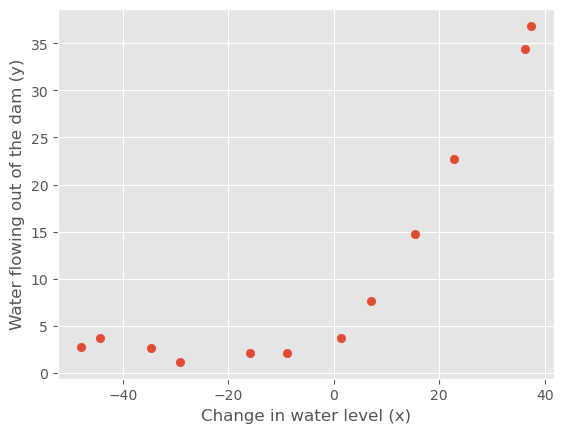

In [93]:
plt.scatter(X, y)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
X.shape, y.shape

### Regularized linear regression cost function

Recall that regularized linear regression has the following cost function:

$$
J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)} \right)^2 + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_{j}^2,
$$

where $ \lambda $ is a regularization parameter which controls the degree of regularization (thus, helping to prevent overfitting). The regularization term puts a penalty on the overall cost $ J $. As the magnitudes of the model parameters $ \theta_j $ increase, the penalty increases as well. Note that you should not regularize the $ \theta_0 $ term.

Wr now complete the code in `linearRegCostFunction`. Your write a function to calculate the regularized linear regression cost function. We try to vectorize your code and avoid writing loops. We run the cost function using `theta` initialized at `[1; 1]`. We should expect to see an output of 303.993.


In [94]:
def hypothesis(X, theta):
    theta = np.array(theta)
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ theta

hypothesis(X, [1, 1])

array([-14.93675813, -28.15297922,  37.18954863,  38.49218733,
       -47.05882945,  -7.94145794,  16.30779289, -33.70626581,
         2.38915437, -43.38375985,   8.01350208,  23.76274892])

In [95]:
def cost(X, y, mu=0):
    m = len(y)
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    def J(theta):
        theta = np.array(theta)
        h = X @ theta
        term1 = np.sum((h - y)**2)
        term2 = mu * np.sum(theta[1:])
        return (term1 + term2) / (2*m)
    return J

cost(X, y)([1, 1])

303.9515255535976

### Regularized linear regression gradient

Correspondingly, the partial derivative of regularized linear regression’s cost for $ \theta_j $ is defined as:

$$
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_j \quad \text{for } j = 0
$$

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_j + \frac{\lambda}{m} \theta_j \quad \text{for } j \geq 1
$$

We create `gradient` to calculate the gradient. When you are finished, we run the gradient function using `theta` initialized at $[1; 1]$. We should expect to see a gradient of $[-15.30; 598.250]$.


In [96]:
def gradient(X, y, mu=0):
    m = len(y)
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    def G(theta):
        theta = np.array(theta)
        h = X @ theta
        grads = []
        for j in range(len(theta)):
            grads_unreg = np.sum((h - y) * X[:, j]) / m
            if j == 0: grads.append(grads_unreg)
            else: grads.append(grads_unreg + mu*theta[j]/m)
        return np.array(grads)
    return G

gradient(X, y)([1, 1])

array([-15.30301567, 598.16741084])

### Fitting linear regression
We now run the code in `trainLinearReg` to compute the optimal value of $\theta$. This training function uses `scipy.optimize.minimize` to optimize the cost function.

In this part, we set the regularization parameter $\lambda$ to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension. In the later parts of the exercise, you will be using polynomial regression with regularization.

Finally, we should also plot the best fit line. 
The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. 
While visualizing the best fit as shown is one possible way to debug the learning algorithm, it is not always easy to visualize the data and model. 
In the next section, we will implement a function to generate learning curves that can help debug the learning algorithm even if it is not easy to visualize the data.


In [97]:
def trainLinearRegression(X, y, theta0=None, mu=0):
    theta = np.zeros(X.shape[1]+1) if theta0 is None else theta0
    J = cost(X, y, mu)
    G = gradient(X, y, mu)
    result = scipy.optimize.minimize(fun=J, jac=G, x0=theta, method='BFGS')
    return result

In [98]:
model = trainLinearRegression(X, y)
theta = model.x
theta

array([13.08790351,  0.36777923])

In [99]:
y_hat = hypothesis(X, theta)

((12, 1), (12,))

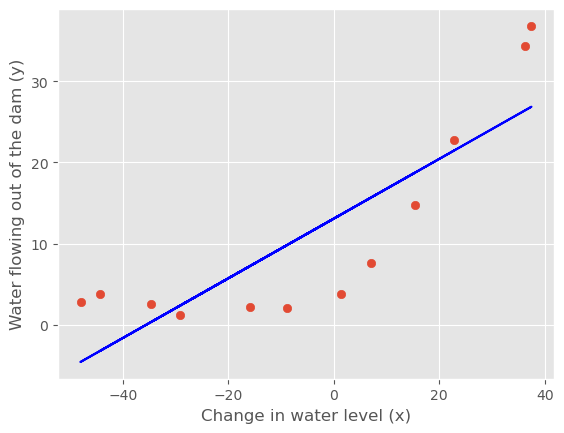

In [100]:
plt.scatter(X, y)
plt.plot(X, y_hat, color='blue')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
X.shape, y.shape